In [226]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, RandomFlip, RandomRotation
from keras.preprocessing.image import ImageDataGenerator
import numpy as np 
import matplotlib.pyplot as plt
import pickle
from PIL import ImageFile, Image
import datetime
import os
from keras.regularizers import l1_l2, l2
import keras 



In [195]:
def display_image_in_actual_size(img_path):
    dpi = 100
    img_data = plt.imread(img_path)
    height, width, depth = img_data.shape
    # What size does the figure need to be in inches to fit
    # the image?
    figsize = width / float(dpi), height / float(dpi)
    # Create a figure of the right size with one axis that
    # takes up the full figure
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])
    # Hide spines, ticks, etc.
    ax.axis('off')
    # Display the image.
    ax.imshow(img_data, cmap='gray')
    plt.show()

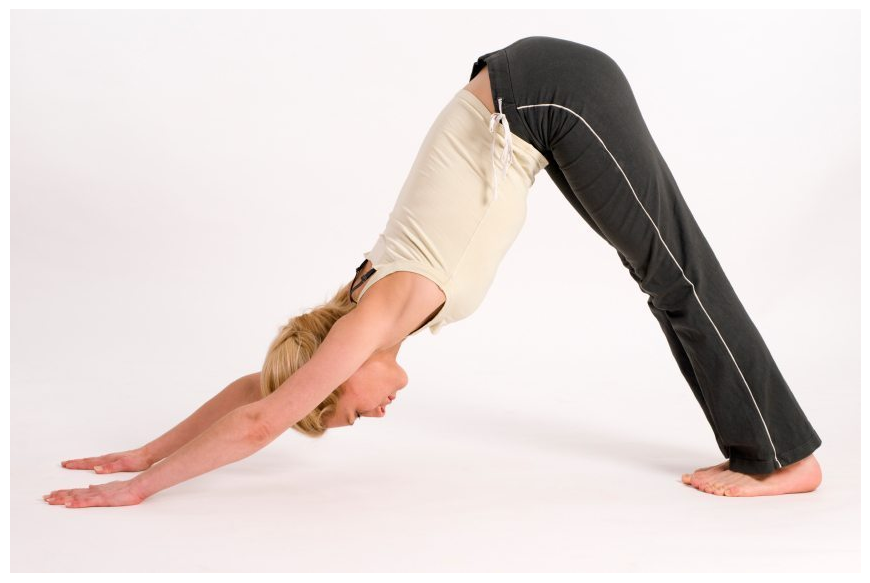

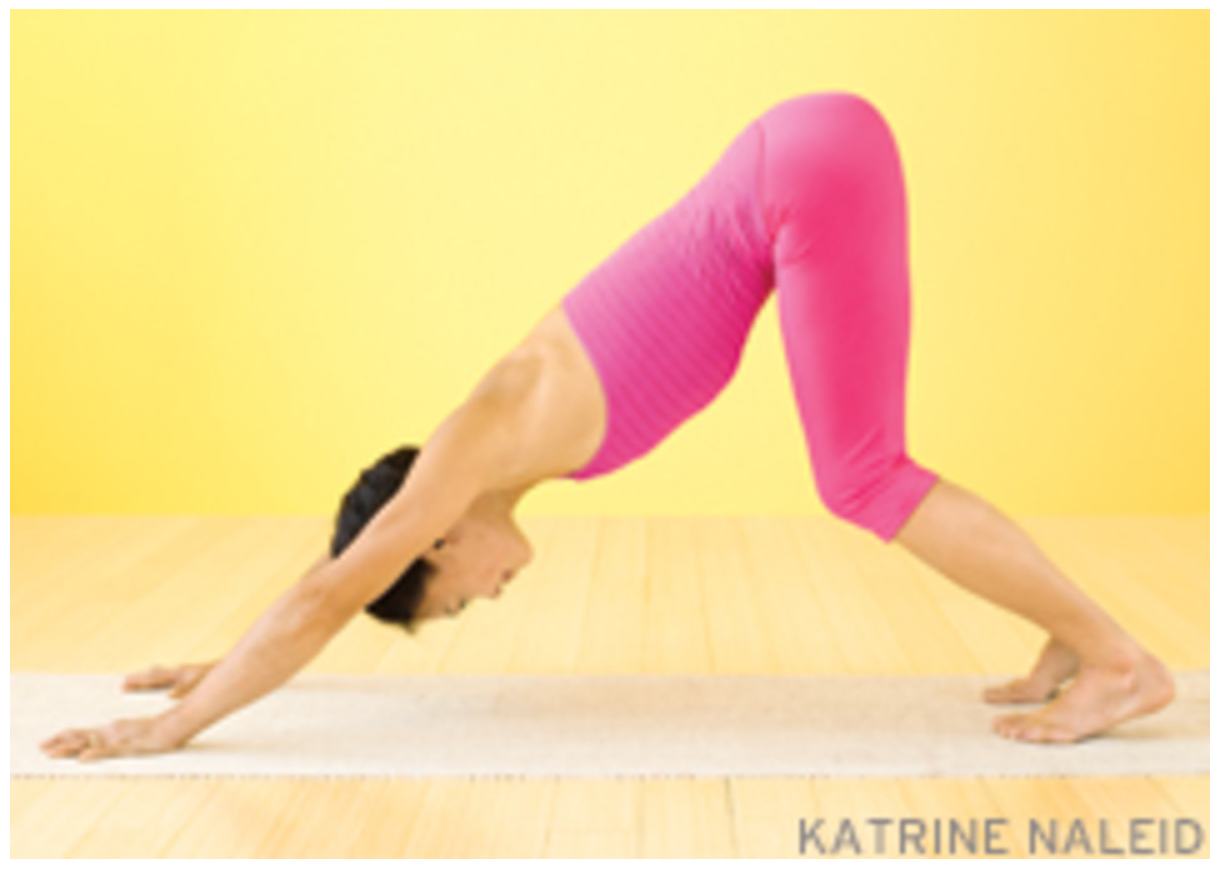

In [196]:
path = 'DATASET/TRAIN/downdog/'
images = ['00000128.jpg', '00000130.jpg']

for img in images:
    display_image_in_actual_size(path + img)

# Loading and preprocessing the data

In [197]:
# In this cell we've defined:
#  - the directory path of the dataset,
#  - the batch size for loading images,
#  - the image size (all images will be resized to this size) 
#  - the proportion of the dataset to be used for validation

TRAIN_PATH = 'DATASET/TRAIN/'
TEST_PATH = 'DATASET/TRAIN/'

BATCH_SIZE = 32
NUM_EPOCHS = 20

pixels =128
IMAGE_SIZE = (pixels, pixels)

VALIDATTION_PERCENTAGE = 0.2

In [198]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, validation_split=.20)

In [208]:
dataflow_kwargs = dict(target_size=IMAGE_SIZE, batch_size=BATCH_SIZE, interpolation="bilinear", color_mode="grayscale")

train_generator = datagen.flow_from_directory(TRAIN_PATH, subset="training", shuffle=True,  **dataflow_kwargs)
validation_generator = datagen.flow_from_directory(TRAIN_PATH, subset="validation", shuffle=False,  **dataflow_kwargs)

testgen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255) # Generator for our validation data
test_generator = datagen.flow_from_directory(TEST_PATH, shuffle=False,  **dataflow_kwargs)

Found 862 images belonging to 5 classes.
Found 213 images belonging to 5 classes.
Found 1075 images belonging to 5 classes.


In [215]:
imgs, labels = next(train_generator)
print('batch shape ' + str(imgs.shape))
print('labels shape ' + str(labels.shape))

batch shape (32, 128, 128, 1)
labels shape (32, 5)


In [214]:
# Define the classes
classes = {int(v): k for k, v in train_generator.class_indices.items()}


{0: 'downdog', 1: 'goddess', 2: 'plank', 3: 'tree', 4: 'warrior2'}

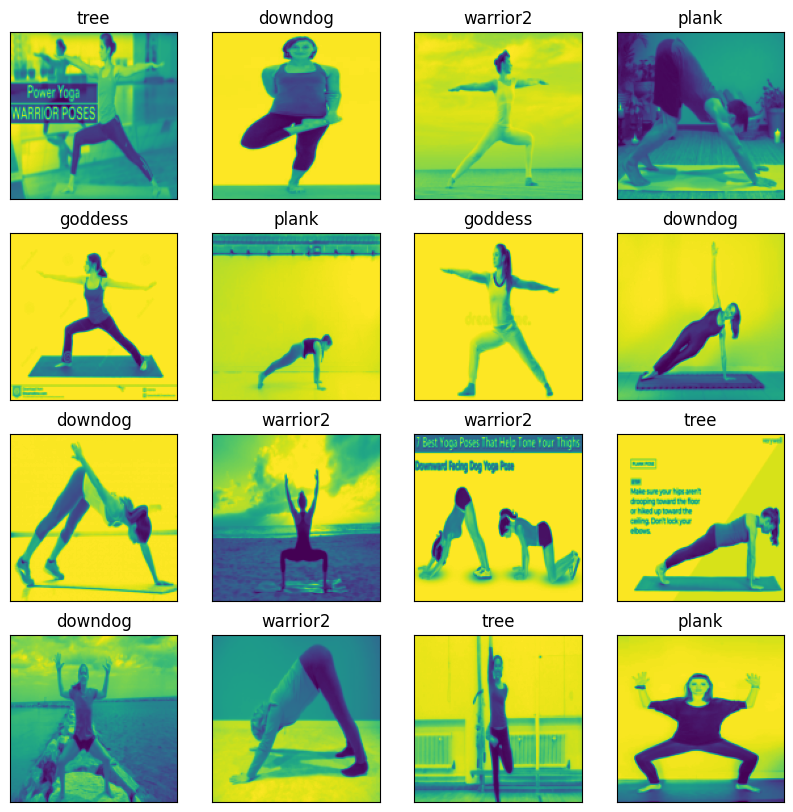

In [216]:
import matplotlib.pyplot as plt

# Visualize the images and their labels
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10,10))
for i, ax in enumerate(axes.flat):
    # Plot image
    ax.imshow(x_batch[i])
    # Set title to the corresponding label
    ax.set_title(classes[np.argmax(labels[i])])
    # Remove axis ticks
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()


# Creating the model 

In [218]:
# define input shape
input_shape = (pixels, pixels, 1)

# initialize the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    Flatten(),
    
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(5, activation='softmax')
])


# compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])



In [219]:
# A brief summary of the model and parameters
model.summary(line_length = 75)

Model: "sequential_5"
___________________________________________________________________________
 Layer (type)                    Output Shape                  Param #     
 conv2d (Conv2D)                 (None, 126, 126, 32)          320         
                                                                           
 max_pooling2d (MaxPooling2D)    (None, 63, 63, 32)            0           
                                                                           
 conv2d_1 (Conv2D)               (None, 61, 61, 64)            18496       
                                                                           
 max_pooling2d_1 (MaxPooling2D)  (None, 30, 30, 64)            0           
                                                                           
 conv2d_2 (Conv2D)               (None, 28, 28, 128)           73856       
                                                                           
 max_pooling2d_2 (MaxPooling2D)  (None, 14, 14, 128)           0  

In [220]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

### Tensorboard Callback

In [221]:
log_dir = 'logs/fit/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, profile_batch=0)

## Trainning the model 

In [222]:
# Train the network
ImageFile.LOAD_TRUNCATED_IMAGES = True

model.fit(
    train_generator, 
    epochs = NUM_EPOCHS, 
    callbacks = [tensorboard_callback], 
    validation_data = validation_generator,
    verbose = 2
)

Epoch 1/20


/home/user01/miniconda3/envs/lab/lib/python3.11/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
2023-04-27 21:58:55.524320: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-04-27 21:59:05.493125: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 - 12s - loss: 1.6058 - accuracy: 0.2367 - val_loss: 1.6025 - val_accuracy: 0.2347 - 12s/epoch - 434ms/step
Epoch 2/20
27/27 - 10s - loss: 1.5775 - accuracy: 0.3121 - val_loss: 1.5472 - val_accuracy: 0.3239 - 10s/epoch - 383ms/step
Epoch 3/20
27/27 - 11s - loss: 1.5178 - accuracy: 0.3469 - val_loss: 1.4536 - val_accuracy: 0.3756 - 11s/epoch - 389ms/step
Epoch 4/20
27/27 - 11s - loss: 1.4547 - accuracy: 0.3596 - val_loss: 1.3924 - val_accuracy: 0.4272 - 11s/epoch - 409ms/step
Epoch 5/20
27/27 - 11s - loss: 1.3510 - accuracy: 0.4026 - val_loss: 1.3327 - val_accuracy: 0.4319 - 11s/epoch - 413ms/step
Epoch 6/20
27/27 - 11s - loss: 1.2701 - accuracy: 0.4466 - val_loss: 1.2212 - val_accuracy: 0.4601 - 11s/epoch - 411ms/step
Epoch 7/20
27/27 - 11s - loss: 1.2093 - accuracy: 0.4559 - val_loss: 1.3159 - val_accuracy: 0.3756 - 11s/epoch - 394ms/step
Epoch 8/20
27/27 - 10s - loss: 1.1724 - accuracy: 0.4849 - val_loss: 1.2020 - val_accuracy: 0.4883 - 10s/epoch - 389ms/step
Epoch 9/20
27/27 - 

## Testing our model

In [223]:
test_loss, test_accuracy = model.evaluate(test_generator)

2023-04-27 22:03:29.081030: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


34/34 [==============================] - 8s 244ms/step - loss: 0.4763 - accuracy: 0.8633


## Visualizing in Tensorboard

In [224]:
os.environ['TENSORBOARD_BINARY'] = '/home/user01/miniconda3/envs/lab/bin/tensorboard'

%load_ext tensorboard
%tensorboard --logdir 'logs/fit/'


## Regularization
Regularization is a set of techniques that can prevent overfitting in neural networks and thus improve the accuracy of a Deep Learning model when facing completely new data from the problem domain.   
In this notebook, we will address the most popular regularization techniques which are: 
- L1 & L2
- Dropout
- Data Augmentation
- Early Stopping
- Batch normalization


### L1 & L2

In [242]:
# define input shape
input_shape = (pixels, pixels, 1)

# initialize the model
model2 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, kernel_regularizer=l2(.01)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(.01)),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(.01)),
    MaxPooling2D(pool_size=(2, 2)),
    
    Flatten(),
    
    Dense(16, activation='relu', kernel_regularizer=l2(.01)),
    
    Dense(16, activation='relu', kernel_regularizer=l2(.01)),
    
    Dense(5, activation='softmax')
])

# add convolutional layers


# compile the model
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])



In [243]:
# Train the network
ImageFile.LOAD_TRUNCATED_IMAGES = True

model2.fit(
    train_generator, 
    epochs = NUM_EPOCHS, 
    callbacks = [tensorboard_callback], 
    validation_data = validation_generator,
    verbose = 2
)

Epoch 1/20


2023-04-27 22:32:50.236352: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-04-27 22:33:00.156994: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 - 11s - loss: 2.7358 - accuracy: 0.2425 - val_loss: 2.2383 - val_accuracy: 0.2441 - 11s/epoch - 426ms/step
Epoch 2/20
27/27 - 10s - loss: 2.0425 - accuracy: 0.2448 - val_loss: 1.8980 - val_accuracy: 0.2817 - 10s/epoch - 379ms/step
Epoch 3/20
27/27 - 10s - loss: 1.8632 - accuracy: 0.2599 - val_loss: 1.8012 - val_accuracy: 0.2488 - 10s/epoch - 382ms/step
Epoch 4/20
27/27 - 10s - loss: 1.7720 - accuracy: 0.3109 - val_loss: 1.7255 - val_accuracy: 0.2582 - 10s/epoch - 381ms/step
Epoch 5/20
27/27 - 10s - loss: 1.7066 - accuracy: 0.3654 - val_loss: 1.6670 - val_accuracy: 0.3897 - 10s/epoch - 384ms/step
Epoch 6/20
27/27 - 11s - loss: 1.6303 - accuracy: 0.4107 - val_loss: 1.6394 - val_accuracy: 0.4038 - 11s/epoch - 400ms/step
Epoch 7/20
27/27 - 11s - loss: 1.5605 - accuracy: 0.4524 - val_loss: 1.5195 - val_accuracy: 0.5446 - 11s/epoch - 389ms/step
Epoch 8/20
27/27 - 11s - loss: 1.4258 - accuracy: 0.5290 - val_loss: 1.4002 - val_accuracy: 0.5728 - 11s/epoch - 393ms/step
Epoch 9/20
27/27 - 

### Data augmentation

Image rotation: Rotating the image can be a useful technique for yoga pose classification as different poses can have different orientations. we'll try rotating the images by small angles, such as 5 or 10 degrees.

Image flipping: Flipping the image horizontally can help to increase the amount of training data and provide variations in the pose. However, flipping the image vertically may not be appropriate for yoga poses as it can change the nature of the pose.

Image cropping: Cropping the image can help to focus on specific parts of the pose, such as the upper body or lower body. This can be useful for differentiating between similar poses.

Image zooming: Zooming in or out on the image can help to increase the variation in the dataset and provide different perspectives of the pose.

Image shifting: Shifting the image horizontally or vertically can help to create new variations of the pose.

Image scaling: Scaling the image can help to increase the variation in the dataset and provide different sizes of the pose.

In [33]:
# define input shape
input_shape = (pixels, pixels, 1)

# initialize the model
model3 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    Flatten(),
    
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),    
    Dense(5, activation='softmax')
])




# compile the model
model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])



In [173]:
datagen_train2 = ImageDataGenerator(
    rotation_range=10, 
    width_shift_range=4,  
    height_shift_range=0.1, 
    zoom_range=0.1,  
    horizontal_flip=True,  
    fill_mode='nearest', 
    rescale=1./255, 
)

### Dropout

In [247]:
# define input shape
input_shape = (pixels, pixels, 1)

# initialize the model
model4 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    Flatten(),
    
    Dense(16, activation='relu'),
    Dropout(0.2),
    
    Dense(16, activation='relu'),
    Dropout(0.2),
    
    Dense(5, activation='softmax')
])

# compile the model
model4.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [248]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

model4.fit(
    train_generator, 
    epochs = NUM_EPOCHS, 
    validation_data = validation_generator,
    verbose = 2
)

Epoch 1/20


2023-04-27 22:46:32.007084: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-04-27 22:46:41.567444: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 - 11s - loss: 1.6113 - accuracy: 0.2216 - val_loss: 1.5938 - val_accuracy: 0.2347 - 11s/epoch - 410ms/step
Epoch 2/20
27/27 - 10s - loss: 1.5867 - accuracy: 0.2680 - val_loss: 1.5496 - val_accuracy: 0.3239 - 10s/epoch - 382ms/step
Epoch 3/20
27/27 - 10s - loss: 1.5103 - accuracy: 0.2877 - val_loss: 1.4216 - val_accuracy: 0.4507 - 10s/epoch - 379ms/step
Epoch 4/20
27/27 - 10s - loss: 1.3946 - accuracy: 0.3817 - val_loss: 1.3110 - val_accuracy: 0.5070 - 10s/epoch - 386ms/step
Epoch 5/20
27/27 - 11s - loss: 1.2805 - accuracy: 0.4733 - val_loss: 1.1208 - val_accuracy: 0.5493 - 11s/epoch - 394ms/step
Epoch 6/20
27/27 - 10s - loss: 1.1593 - accuracy: 0.5278 - val_loss: 1.0441 - val_accuracy: 0.5587 - 10s/epoch - 389ms/step
Epoch 7/20
27/27 - 10s - loss: 1.0521 - accuracy: 0.5731 - val_loss: 0.9191 - val_accuracy: 0.6526 - 10s/epoch - 386ms/step
Epoch 8/20
27/27 - 10s - loss: 0.9603 - accuracy: 0.6137 - val_loss: 0.7878 - val_accuracy: 0.6995 - 10s/epoch - 384ms/step
Epoch 9/20
27/27 - 

### Batch normalization

In [250]:
from tensorflow.keras.layers import BatchNormalization

# initialize the model
model5 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    
    Flatten(),
    
    Dense(16, activation='relu'),
    BatchNormalization(),
    Dense(16, activation='relu'),
    BatchNormalization(),    
    Dense(5, activation='softmax')
])


In [251]:

# compile the model
model5.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [252]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

model5.fit(
    train_generator, 
    epochs = NUM_EPOCHS, 
    validation_data = validation_generator,
    verbose = 2
)

Epoch 1/20


2023-04-27 22:50:59.325926: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-04-27 22:51:11.087040: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 - 13s - loss: 1.4766 - accuracy: 0.3898 - val_loss: 1.6147 - val_accuracy: 0.2113 - 13s/epoch - 494ms/step
Epoch 2/20
27/27 - 12s - loss: 1.0618 - accuracy: 0.6206 - val_loss: 1.5793 - val_accuracy: 0.2535 - 12s/epoch - 435ms/step
Epoch 3/20
27/27 - 12s - loss: 0.9487 - accuracy: 0.6601 - val_loss: 1.5826 - val_accuracy: 0.2817 - 12s/epoch - 432ms/step
Epoch 4/20
27/27 - 12s - loss: 0.7530 - accuracy: 0.7599 - val_loss: 1.5434 - val_accuracy: 0.3521 - 12s/epoch - 449ms/step
Epoch 5/20
27/27 - 11s - loss: 0.5603 - accuracy: 0.8619 - val_loss: 1.6376 - val_accuracy: 0.2347 - 11s/epoch - 425ms/step
Epoch 6/20
27/27 - 11s - loss: 0.4223 - accuracy: 0.9095 - val_loss: 1.5362 - val_accuracy: 0.2817 - 11s/epoch - 423ms/step
Epoch 7/20
27/27 - 11s - loss: 0.3055 - accuracy: 0.9548 - val_loss: 1.5594 - val_accuracy: 0.2441 - 11s/epoch - 422ms/step
Epoch 8/20
27/27 - 11s - loss: 0.2293 - accuracy: 0.9780 - val_loss: 1.6292 - val_accuracy: 0.2488 - 11s/epoch - 424ms/step
Epoch 9/20
27/27 - 

KeyboardInterrupt: 

### Early Stopping

In [ ]:
# Defining early stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    mode = 'auto',    
    min_delta = 0,
    patience = 2,
    verbose = 0,
    restore_best_weights = True
)

## final Model